<a href="https://colab.research.google.com/github/mouni25/ML_Projects/blob/main/Copy_of_Assignment_DT_Instructions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b>Building ML Model :  Decsion Trees </b>

In [ ]:
# loading glove vectors 
import pickle
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

# <font color='red'> <b>Objectives</b></font>

<ol>
    <li><strong>Apply Decision Tree Classifier(DecisionTreeClassifier) on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical, numerical features +  preprocessed_essay (TFIDF) + Sentiment scores(preprocessed_essay)</li>
            <li><font color='red'>Set 2</font>: categorical, numerical features +  preprocessed_essay (TFIDF W2V) + Sentiment scores(preprocessed_essay)</li>        </ul>
    </li>
    <li><strong>The hyper paramter tuning (best `depth` in range [1, 5, 10, 50], and the best `min_samples_split` in range [5, 10, 100, 500])</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>find the best hyper paramter using k-fold cross validation</li>
        </ul>
    </li>
    

In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
import re
import pickle
from tqdm import tqdm
import os
from chart_studio import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

<h1>1. Decision Tree </h1>

## 1.1 Loading Data

In [ ]:
import pandas
data = pandas.read_csv('preprocessed_data_donorschoose.csv')

In [ ]:
y = data['project_is_approved'].values
X = data.drop(['project_is_approved'], axis=1)
print(X.shape)

(109248, 8)


In [ ]:
#Sentiment scores for essay
neg,pos,neu,compound=[],[],[],[]
for ess in tqdm(X['essay']):
  ss = sid.polarity_scores(ess)
  neg.append(ss['neg'])
  pos.append(ss['pos'])
  neu.append(ss['neu'])
  compound.append(ss['compound'])



100%|██████████| 109248/109248 [03:12<00:00, 568.77it/s]


In [ ]:
X['neg']=neg
X['pos']=pos
X['neu']=neu
X['compound']=compound

In [ ]:
print(X.shape)

(109248, 12)


In [ ]:
X.tail(3)

school_state teacher_prefix  ...    neu  compound
109245           il            mrs  ...  0.868    0.7960
109246           hi            mrs  ...  0.643    0.9866
109247           ca            mrs  ...  0.641    0.9913

[3 rows x 12 columns]

In [ ]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)

## 1.2 Encoding Data

In [ ]:
#Encoding essay TFIDF
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

print("="*100)


vectorizer_essay_tfidf = TfidfVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer_essay_tfidf.fit(X_train['essay'].values) # fit has to happen only on train data

# we use the fitted TfidfVectorizer to convert the text to vector
X_train_essay_tfidf = vectorizer_essay_tfidf.transform(X_train['essay'].values)
X_test_essay_tfidf = vectorizer_essay_tfidf.transform(X_test['essay'].values)

print("After vectorizations")
print(X_train_essay_tfidf.shape, y_train.shape)
print(X_test_essay_tfidf.shape, y_test.shape)
print("="*100)


(73196, 12) (73196,)
(36052, 12) (36052,)
After vectorizations
(73196, 5000) (73196,)
(36052, 5000) (36052,)


In [ ]:
#Encoding essay tfidfw2v

tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['essay'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

# compute average word2vec for each review in training set.
tfidf_w2v_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['essay']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_train.append(vector)

print(len(tfidf_w2v_vectors_train))
print(len(tfidf_w2v_vectors_train[0]))



100%|██████████| 73196/73196 [02:26<00:00, 498.30it/s]

73196
300


In [ ]:
# compute average word2vec for each review in test set.
tfidf_w2v_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['essay']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_test.append(vector)

print(len(tfidf_w2v_vectors_test))
print(len(tfidf_w2v_vectors_test[0]))

100%|██████████| 36052/36052 [01:14<00:00, 483.11it/s]

36052
300


In [ ]:
#encoding School state
vectorizer_st = CountVectorizer()
vectorizer_st.fit(X_train['school_state'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_state_ohe = vectorizer_st.transform(X_train['school_state'].values)
X_test_state_ohe = vectorizer_st.transform(X_test['school_state'].values)

print("After vectorizations")
print(X_train_state_ohe.shape, y_train.shape)
print(X_test_state_ohe.shape, y_test.shape)
print(vectorizer_st.get_feature_names())
print("="*100)


After vectorizations
(73196, 51) (73196,)
(36052, 51) (36052,)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']


In [ ]:
#encoding teacher prefix
vectorizer_prefix = CountVectorizer()
vectorizer_prefix.fit(X_train['teacher_prefix'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_teacher_ohe = vectorizer_prefix.transform(X_train['teacher_prefix'].values)
X_test_teacher_ohe = vectorizer_prefix.transform(X_test['teacher_prefix'].values)

print("After vectorizations")
print(X_train_teacher_ohe.shape, y_train.shape)
print(X_test_teacher_ohe.shape, y_test.shape)
print(vectorizer_prefix.get_feature_names())
print("="*100)


After vectorizations
(73196, 5) (73196,)
(36052, 5) (36052,)
['dr', 'mr', 'mrs', 'ms', 'teacher']


In [ ]:
# encoding project grade category
vectorizer_grade = CountVectorizer()
vectorizer_grade.fit(X_train['project_grade_category'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_grade_ohe = vectorizer_grade.transform(X_train['project_grade_category'].values)
X_test_grade_ohe = vectorizer_grade.transform(X_test['project_grade_category'].values)

print("After vectorizations")
print(X_train_grade_ohe.shape, y_train.shape)
print(X_test_grade_ohe.shape, y_test.shape)
print(vectorizer_grade.get_feature_names())
print("="*100)


After vectorizations
(73196, 4) (73196,)
(36052, 4) (36052,)
['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']


In [ ]:
#encoding clean categories
vectorizer_cat = CountVectorizer()
vectorizer_cat.fit(X_train['clean_categories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_categories_ohe = vectorizer_cat.transform(X_train['clean_categories'].values)
X_test_categories_ohe = vectorizer_cat.transform(X_test['clean_categories'].values)

print("After vectorizations")
print(X_train_categories_ohe.shape, y_train.shape)
print(X_test_categories_ohe.shape, y_test.shape)
print(vectorizer_cat.get_feature_names())
print("="*100)


After vectorizations
(73196, 9) (73196,)
(36052, 9) (36052,)
['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth']


In [ ]:
#encoding clean_subcategories
vectorizer_subcat = CountVectorizer()
vectorizer_subcat.fit(X_train['clean_subcategories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_subcategories_ohe = vectorizer_subcat.transform(X_train['clean_subcategories'].values)
X_test_subcategories_ohe = vectorizer_subcat.transform(X_test['clean_subcategories'].values)

print("After vectorizations")
print(X_train_subcategories_ohe.shape, y_train.shape)
print(X_test_subcategories_ohe.shape, y_test.shape)
print(vectorizer_subcat.get_feature_names())
print("="*100)


After vectorizations
(73196, 30) (73196,)
(36052, 30) (36052,)
['appliedsciences', 'care_hunger', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'extracurricular', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performingarts', 'socialsciences', 'specialneeds', 'teamsports', 'visualarts', 'warmth']


In [ ]:
#encoding price
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
normalizer.fit(X_train['price'].values.reshape(-1,1))

X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(-1,1))
X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_price_norm.shape, y_train.shape)
print(X_test_price_norm.shape, y_test.shape)
print("="*100)


After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)


In [ ]:
#encoding teacher_number_of_previously_posted_projects
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

X_train_prevprojscnt_norm = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_prevprojscnt_norm = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))


print("After vectorizations")
print(X_train_prevprojscnt_norm.shape, y_train.shape)
print(X_test_prevprojscnt_norm.shape, y_test.shape)
print("="*100)


After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)


In [ ]:
#encoding pos
normalizer = Normalizer()
normalizer.fit(X_train['pos'].values.reshape(-1,1))

X_train_pos_norm = normalizer.transform(X_train['pos'].values.reshape(-1,1))
X_test_pos_norm = normalizer.transform(X_test['pos'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_pos_norm.shape, y_train.shape)
print(X_test_pos_norm.shape, y_test.shape)
print("="*100)


After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)


In [ ]:
#encoding neg
normalizer = Normalizer()
normalizer.fit(X_train['neg'].values.reshape(-1,1))

X_train_neg_norm = normalizer.transform(X_train['neg'].values.reshape(-1,1))
X_test_neg_norm = normalizer.transform(X_test['neg'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_neg_norm.shape, y_train.shape)
print(X_test_neg_norm.shape, y_test.shape)
print("="*100)


After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)


In [ ]:
#encoding neu
normalizer = Normalizer()
normalizer.fit(X_train['neu'].values.reshape(-1,1))

X_train_neu_norm = normalizer.transform(X_train['neu'].values.reshape(-1,1))
X_test_neu_norm = normalizer.transform(X_test['neu'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_neu_norm.shape, y_train.shape)
print(X_test_neu_norm.shape, y_test.shape)
print("="*100)


After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)


In [ ]:
#encoding compound
normalizer = Normalizer()
normalizer.fit(X_train['compound'].values.reshape(-1,1))

X_train_compound_norm = normalizer.transform(X_train['compound'].values.reshape(-1,1))
X_test_compound_norm = normalizer.transform(X_test['compound'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_compound_norm.shape, y_train.shape)
print(X_test_compound_norm.shape, y_test.shape)
print("="*100)


After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)


# **Decision Tree on SET 1:** categorical, numerical features + preprocessed_essay (TFIDF) + Sentiment scores(preprocessed_essay)

In [ ]:
#Concatinating all the features : SET1
from scipy.sparse import hstack
X_tr_set1 = hstack((X_train_essay_tfidf, X_train_state_ohe, X_train_teacher_ohe, X_train_grade_ohe,X_train_categories_ohe,X_train_subcategories_ohe, X_train_price_norm,X_train_prevprojscnt_norm,X_train_neg_norm,X_train_pos_norm,X_train_neu_norm,X_train_compound_norm)).tocsr()
X_te_set1= hstack((X_test_essay_tfidf, X_test_state_ohe, X_test_teacher_ohe, X_test_grade_ohe, X_test_categories_ohe,X_test_subcategories_ohe, X_test_price_norm,X_test_prevprojscnt_norm,X_test_neg_norm,X_test_pos_norm,X_test_neu_norm,X_test_compound_norm)).tocsr()

print("Final Data matrix")
print(X_tr_set1.shape, y_train.shape)
print(X_te_set1.shape, y_test.shape)
print("="*100)

Final Data matrix
(73196, 5105) (73196,)
(36052, 5105) (36052,)


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
#dt_set1 = DecisionTreeClassifier() is modified as follows since dataset is heavily imbalanced.

dt_set1 = DecisionTreeClassifier(class_weight='balanced')

parameters = {'max_depth':[1, 5, 10, 50], 'min_samples_split': [5, 10, 100, 500]}

clf1 = GridSearchCV(dt_set1, parameters, cv= 3, scoring='roc_auc', return_train_score = True)

clf1.fit(X_tr_set1, y_train)

train_auc= clf1.cv_results_['mean_train_score']
train_auc_std= clf1.cv_results_['std_train_score']
cv_auc = clf1.cv_results_['mean_test_score'] 
cv_auc_std= clf1.cv_results_['std_test_score']


In [ ]:
bestMaxDepth_1=clf1.best_params_['max_depth']
bestMinSampleSplit_1=clf1.best_params_['min_samples_split']
bestScore_1=clf1.best_score_
print("BEST MAX DEPTH: ",bestMaxDepth_1," BEST MIN SAMPLE SPLIT: ",bestMinSampleSplit_1)

BEST MAX DEPTH:  10  BEST MIN SAMPLE SPLIT:  500


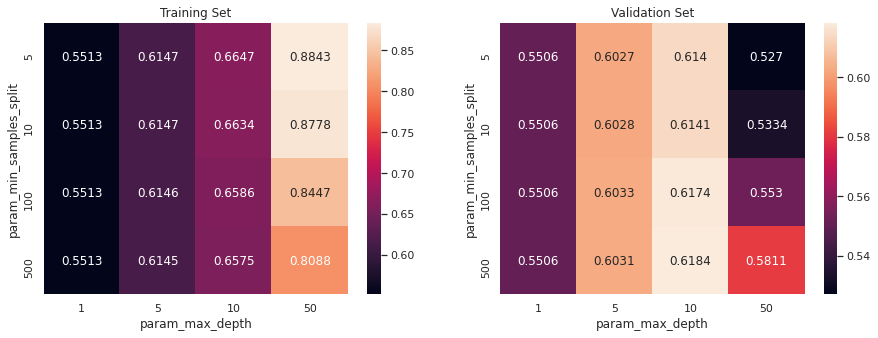

In [ ]:
#plotting with heatmap
#https://seaborn.pydata.org/generated/seaborn.heatmap.html
#http://alanpryorjr.com/visualizations/seaborn/heatmap/heatmap/

sns.set()
max_scores_set1 = pd.DataFrame(clf1.cv_results_).groupby(['param_min_samples_split', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.heatmap(max_scores_set1.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores_set1.mean_test_score, annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Training Set')
ax[1].set_title('Validation Set')
plt.show()

In [ ]:
# #3D scatter plot
# x1=np.array(clf1.best_params_['min_samples_split'])
# y1=np.array(clf1.best_params_['max_depth'])
# z1=np.array(max_scores1.mean_train_score)

# x2=np.array(clf1.best_params_['min_samples_split'])
# y2=np.array(clf1.best_params_['max_depth'])
# z2=np.array(max_scores1.mean_train_score)

# trace1 = go.Scatter3d(x=x1,y=y1,z=z1, name = 'train')
# trace2 = go.Scatter3d(x=x2,y=y2,z=z2, name = 'Cross validation')
# data = [trace1, trace2]
# layout = go.Layout(scene = dict(
#         xaxis = dict(title='n_estimators'),
#         yaxis = dict(title='max_depth'),
#         zaxis = dict(title='AUC'),))

# fig = go.Figure(data=data, layout=layout)
# offline.iplot(fig, filename='3d-scatter-colorscale')

In [ ]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your tr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

In [ ]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    predictions_set1=predictions
    return predictions

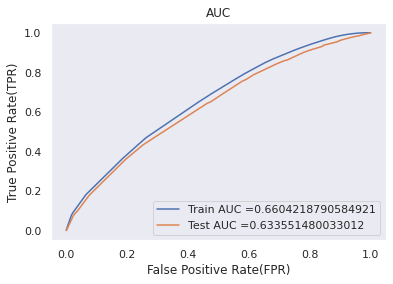

In [ ]:
dt_tfidf = DecisionTreeClassifier(class_weight='balanced',min_samples_split=bestMinSampleSplit_1,max_depth=bestMaxDepth_1)
dt_tfidf.fit(X_tr_set1, y_train)

y_train_pred = batch_predict(dt_tfidf, X_tr_set1)    
y_test_pred = batch_predict(dt_tfidf, X_te_set1)


train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))


plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("AUC")
plt.grid()
plt.show()

In [ ]:
print("="*100)
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

print("Train confusion matrix")
y_tr_prediction_class=predict_with_best_t(y_train_pred, best_t)
print(confusion_matrix(y_train,y_tr_prediction_class ))
print("Test confusion matrix")
y_te_prediction_class=predict_with_best_t(y_test_pred, best_t)
print(confusion_matrix(y_test,y_te_prediction_class))


the maximum value of tpr*(1-fpr) 0.3671803750717431 for threshold 0.854
Train confusion matrix
[[ 6245  4838]
 [21638 40475]]
Test confusion matrix
[[ 2929  2530]
 [10905 19688]]


Text(0.5, 1.0, 'Confusion Matrix for test data')

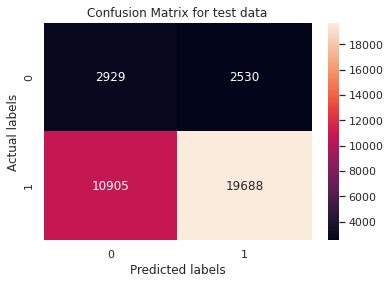

In [ ]:
#heatmap:confusion matrix
ax= plt.subplot()
test_cm=confusion_matrix(y_test, y_te_prediction_class)
sns.heatmap(test_cm, annot=True,fmt="d")
ax.set_xlabel('Predicted labels')
ax.set_ylabel('Actual labels')
ax.set_title('Confusion Matrix for test data') 

In [ ]:
#Getting data points of False Positives from test data
fp_ind=[]
for i in range(len(y_test)):
  if(y_test[i]==0) & (y_te_prediction_class[i]==1):
    fp_ind.append(i)
X_test1=X_test.copy()
X_test1.reset_index(inplace = True,drop=True) 
fp_data=X_test1.loc[[i for i in fp_ind]]
print(fp_data.shape)

(2530, 12)


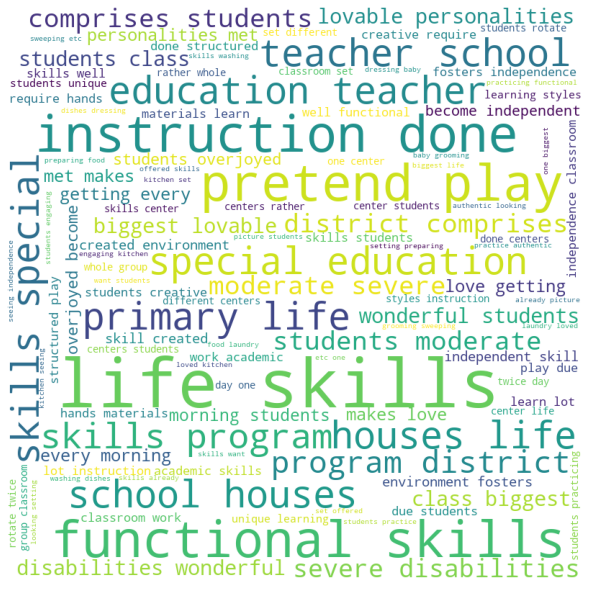

In [ ]:
#WORD CLOUD plotting:feature-essay
#https://www.geeksforgeeks.org/generating-word-cloud-python/
from wordcloud import WordCloud,STOPWORDS

comment_words = '' 
stopwords = set(STOPWORDS) 
  
for val in fp_data['essay']: 
  val = str(val) 
  tokens = val.split() 
for i in range(len(tokens)):
  comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

Text(0, 0.5, 'price')

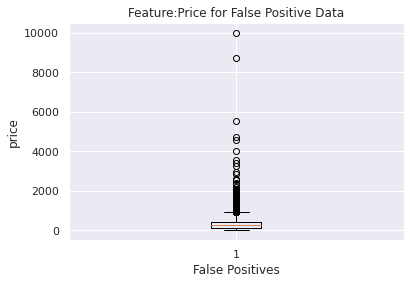

In [ ]:
#box-plot:feature-price
fp_price=fp_data.price
plt.boxplot(fp_price)
plt.title("Feature:Price for False Positive Data")
plt.xlabel("False Positives")
plt.ylabel('price')

Text(0.5, 1.0, 'pdf of previously_posted_projects')

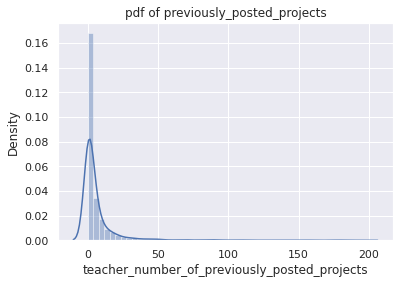

In [ ]:
#pdf of feature:teacher_number_of_previously_posted_projects of fp_data
sns.distplot(fp_data['teacher_number_of_previously_posted_projects'])
plt.title('pdf of previously_posted_projects')

# **Decision Tree on SET 2:** categorical, numerical features + preprocessed_essay (TFIDFw2v) + Sentiment scores(preprocessed_essay)

In [ ]:
#Concatinating all the features : SET2
from scipy.sparse import hstack
X_tr_set2 = hstack((tfidf_w2v_vectors_train, X_train_state_ohe, X_train_teacher_ohe, X_train_grade_ohe,X_train_categories_ohe,X_train_subcategories_ohe, X_train_price_norm,X_train_prevprojscnt_norm,X_train_neg_norm,X_train_pos_norm,X_train_neu_norm,X_train_compound_norm)).tocsr()
X_te_set2= hstack((tfidf_w2v_vectors_test, X_test_state_ohe, X_test_teacher_ohe, X_test_grade_ohe, X_test_categories_ohe,X_test_subcategories_ohe, X_test_price_norm,X_test_prevprojscnt_norm,X_test_neg_norm,X_test_pos_norm,X_test_neu_norm,X_test_compound_norm)).tocsr()

print("Final Data matrix")
print(X_tr_set2.shape, y_train.shape)
print(X_te_set2.shape, y_test.shape)
print("="*100)

Final Data matrix
(73196, 405) (73196,)
(36052, 405) (36052,)


In [ ]:
dt_set2 = DecisionTreeClassifier(class_weight='balanced')

parameters = {'max_depth':[1, 5, 10, 50], 'min_samples_split': [5, 10, 100, 500]}

clf2 = GridSearchCV(dt_set2, parameters, cv= 3, scoring='roc_auc', return_train_
                    score = True)

clf2.fit(X_tr_set2, y_train)

train_auc= clf2.cv_results_['mean_train_score']
train_auc_std= clf2.cv_results_['std_train_score']
cv_auc = clf2.cv_results_['mean_test_score'] 
cv_auc_std= clf2.cv_results_['std_test_score']


In [ ]:
clf2.best_params_

{'max_depth': 5, 'min_samples_split': 5}

In [ ]:
bestMaxDepth_2=clf2.best_params_['max_depth']
bestMinSampleSplit_2=clf2.best_params_['min_samples_split']
bestScore_2=clf2.best_score_
print("BEST MAX DEPTH: ",bestMaxDepth_2,"BEST MIN SAMPLE SPLIT: ",bestMinSampleSplit_2)

BEST MAX DEPTH:  5 BEST MIN SAMPLE SPLIT:  5


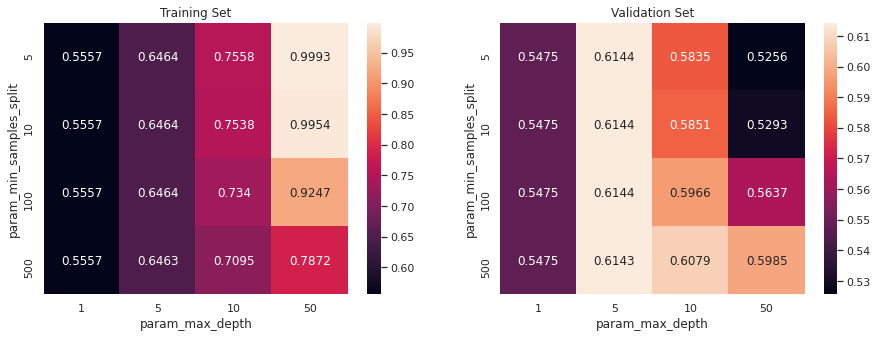

In [ ]:
#http://alanpryorjr.com/visualizations/seaborn/heatmap/heatmap/

sns.set()
max_scores_set2 = pd.DataFrame(clf2.cv_results_).groupby(['param_min_samples_split', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.heatmap(max_scores_set2.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores_set2.mean_test_score, annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Training Set')
ax[1].set_title('Validation Set')
plt.show()

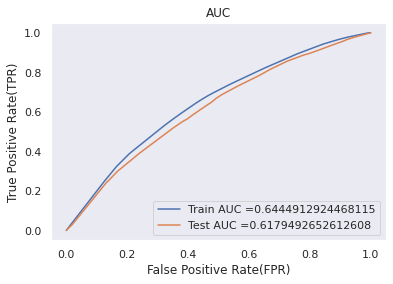

In [ ]:
dt_tfidfw2v = DecisionTreeClassifier(class_weight='balanced',min_samples_split=bestMinSampleSplit_2,max_depth=bestMaxDepth_2)
dt_tfidfw2v.fit(X_tr_set2, y_train)

y_train_pred = batch_predict(dt_tfidfw2v, X_tr_set2)    
y_test_pred = batch_predict(dt_tfidfw2v, X_te_set2)


train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))


plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("AUC")
plt.grid()
plt.show()

In [ ]:
print("="*100)
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

print("Train confusion matrix")
y_tr_prediction_class=predict_with_best_t(y_train_pred, best_t)
print(confusion_matrix(y_train,y_tr_prediction_class ))
print("Test confusion matrix")
y_te_prediction_class=predict_with_best_t(y_test_pred, best_t)
print(confusion_matrix(y_test,y_te_prediction_class))


the maximum value of tpr*(1-fpr) 0.36971853038021174 for threshold 0.856
Train confusion matrix
[[ 6363  4720]
 [22114 39999]]
Test confusion matrix
[[ 2953  2506]
 [11303 19290]]


Text(0.5, 1.0, 'Confusion Matrix')

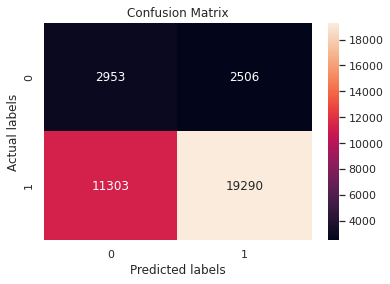

In [ ]:
#heatmap:confusion matrix
ax= plt.subplot()
test_cm=confusion_matrix(y_test, y_te_prediction_class)
sns.heatmap(test_cm, annot=True,fmt="d")
ax.set_xlabel('Predicted labels')
ax.set_ylabel('Actual labels')
ax.set_title('Confusion Matrix') 

In [ ]:
#Getting data points of False Positives from test data
fp_ind2=[]
for i in range(len(y_test)):
  if(y_test[i]==0) & (y_te_prediction_class[i]==1):
    fp_ind2.append(i)
X_test2=X_test.copy()
X_test2.reset_index(inplace = True,drop=True) 
fp_data2=X_test2.loc[[i for i in fp_ind2]]
print(fp_data2.shape)

(2506, 12)


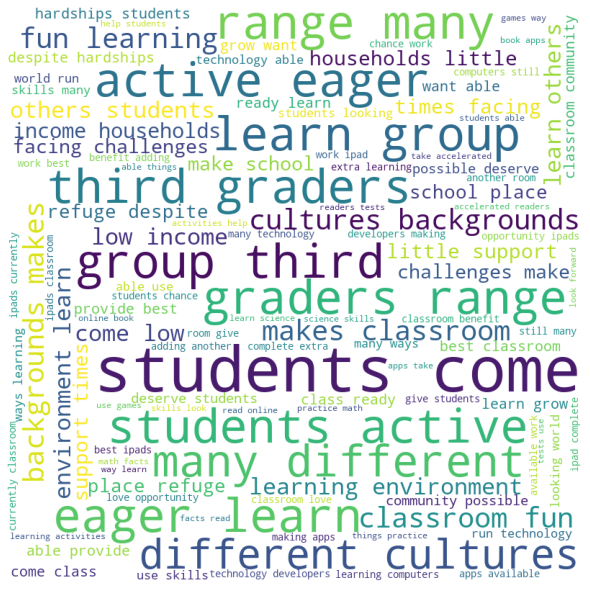

In [ ]:
#WORD CLOUD plotting:feature-essay
#https://www.geeksforgeeks.org/generating-word-cloud-python/
from wordcloud import WordCloud,STOPWORDS

comment_words = '' 
stopwords = set(STOPWORDS) 
  
for val in fp_data2['essay']: 
  val = str(val) 
  tokens = val.split() 
for i in range(len(tokens)):
  comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

Text(0, 0.5, 'price')

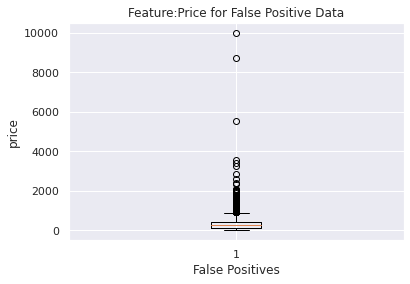

In [ ]:
#box-plot:feature-price
fp_price=fp_data2.price
plt.boxplot(fp_price)
plt.title("Feature:Price for False Positive Data")
plt.xlabel("False Positives")
plt.ylabel('price')

Text(0.5, 1.0, 'pdf of previously_posted_projects')

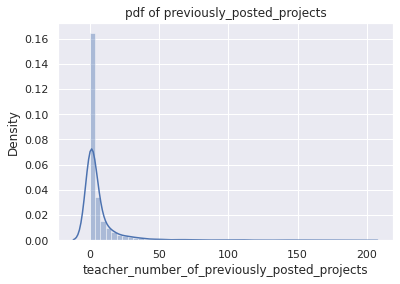

In [ ]:
#pdf of feature:teacher_number_of_previously_posted_projects of fp_data
sns.distplot(fp_data2['teacher_number_of_previously_posted_projects'])
plt.title('pdf of previously_posted_projects')

# **Task2:** Feature Importance in SET1

In [ ]:
dt_fi = DecisionTreeClassifier(class_weight='balanced')
dt_fi.fit(X_tr_set1, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
features=dt_fi.feature_importances_
nzf_cnt=0
for i in range(len(features)):
  if(features[i]>0):
    nzf_cnt = nzf_cnt+1
print("Total no of Features: ",len(features))
print("Num of Non Zero Features:",nzf_cnt)

Total no of Features:  5105
Num of Non Zero Features: 3060


In [ ]:
X_tr_fi=X_tr_set1[:,dt_fi.feature_importances_.argsort()[::-1][:nzf_cnt]]
X_te_fi=X_te_set1[:,dt_fi.feature_importances_.argsort()[::-1][:nzf_cnt]]

In [ ]:
print(X_tr_fi.shape)
print(X_te_fi.shape)


(73196, 3060)
(36052, 3060)


# Applying DT on SET1 features (Non-Zero)

In [ ]:
dt = DecisionTreeClassifier(class_weight='balanced')

parameters = {'max_depth':[1, 5, 10, 50], 'min_samples_split': [5, 10, 100, 500]}

dt_task2 = GridSearchCV(dt, parameters, cv= 3, scoring='roc_auc', return_train_score = True)

dt_task2.fit(X_tr_fi, y_train)

train_auc= dt_task2.cv_results_['mean_train_score']
train_auc_std= dt_task2.cv_results_['std_train_score']
cv_auc = dt_task2.cv_results_['mean_test_score'] 
cv_auc_std= dt_task2.cv_results_['std_test_score']

In [ ]:
bestMaxDepth=dt_task2.best_params_['max_depth']
bestMinSampleSplit=dt_task2.best_params_['min_samples_split']
print("BEST MAX DEPTH: ",bestMaxDepth,"BEST MIN SAMPLE SPLIT: ",bestMinSampleSplit)

BEST MAX DEPTH:  10 BEST MIN SAMPLE SPLIT:  500


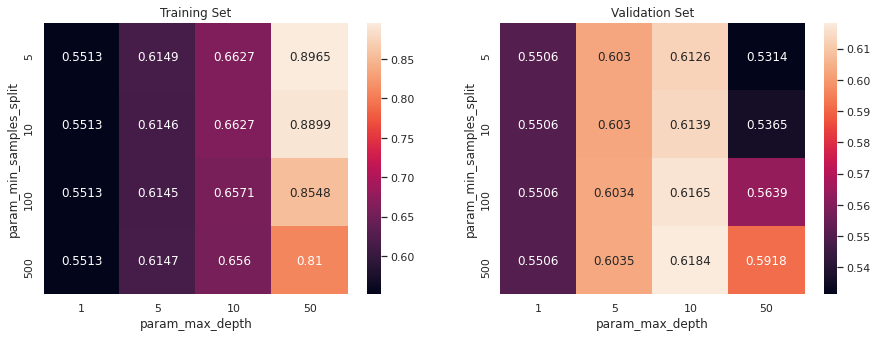

In [ ]:
#http://alanpryorjr.com/visualizations/seaborn/heatmap/heatmap/

sns.set()
max_scores = pd.DataFrame(dt_task2.cv_results_).groupby(['param_min_samples_split', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.heatmap(max_scores.mean_train_score, annot = True, fmt='.4g', ax=ax[0])
sns.heatmap(max_scores.mean_test_score, annot = True, fmt='.4g', ax=ax[1])
ax[0].set_title('Training Set')
ax[1].set_title('Validation Set')
plt.show()

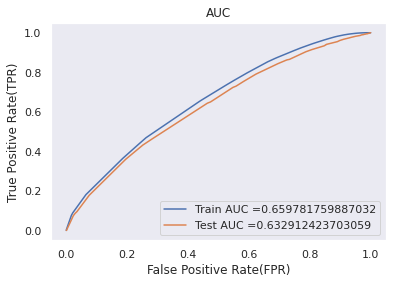

In [ ]:
dt_fi_best = DecisionTreeClassifier(class_weight='balanced',min_samples_split=bestMinSampleSplit,max_depth=bestMaxDepth)
dt_fi_best.fit(X_tr_fi, y_train)

y_train_pred = batch_predict(dt_fi_best, X_tr_fi)    
y_test_pred = batch_predict(dt_fi_best, X_te_fi)


train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))


plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("AUC")
plt.grid()
plt.show()

In [ ]:
print("="*100)
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

print("Train confusion matrix")
y_fi_tr_prediction=predict_with_best_t(y_train_pred, best_t)
print(confusion_matrix(y_train,y_tr_prediction_class ))
print("Test confusion matrix")
y_fi_te_prediction=predict_with_best_t(y_test_pred, best_t)
print(confusion_matrix(y_test,y_te_prediction_class))

the maximum value of tpr*(1-fpr) 0.3671803750717431 for threshold 0.854
Train confusion matrix
[[ 6363  4720]
 [22114 39999]]
Test confusion matrix
[[ 2953  2506]
 [11303 19290]]


Text(0.5, 1.0, 'Confusion Matrix')

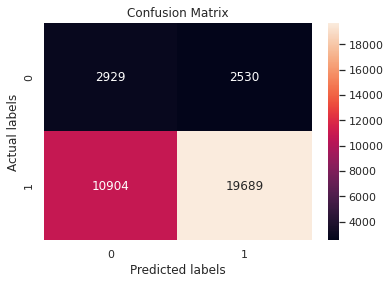

In [ ]:
#heatmap:confusion matrix
ax= plt.subplot()
test_cm=confusion_matrix(y_test, y_fi_te_prediction)
sns.heatmap(test_cm, annot=True,fmt="d")
ax.set_xlabel('Predicted labels')
ax.set_ylabel('Actual labels')
ax.set_title('Confusion Matrix') 

In [ ]:
#Getting data points of False Positives from test data
fp_inds=[]
for i in range(len(y_test)):
  if(y_test[i]==0) & (y_fi_te_prediction[i]==1):
    fp_inds.append(i)
X_test_new=X_test.copy()
X_test_new.reset_index(inplace = True,drop=True) 
fp_data_new=X_test_new.loc[[i for i in fp_inds]]
print(fp_data.shape)


(2530, 12)


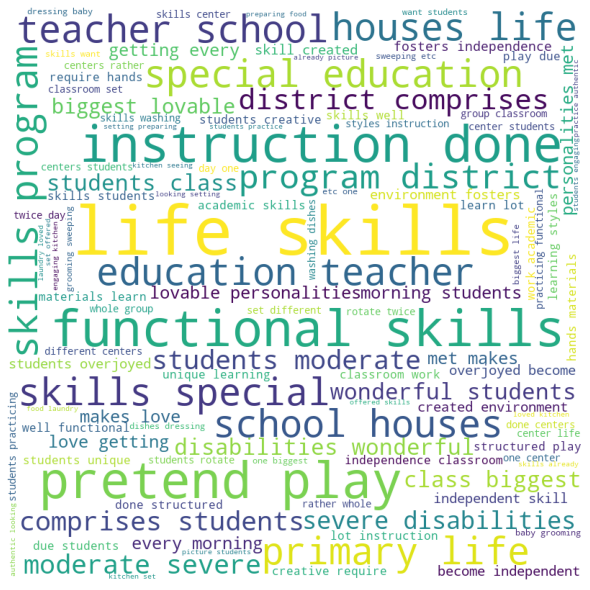

In [ ]:
#WORD CLOUD plotting:feature-essay
#https://www.geeksforgeeks.org/generating-word-cloud-python/

comment_words = '' 
stopwords = set(STOPWORDS) 
  
for val in fp_data_new['essay']: 
  val = str(val) 
  tokens = val.split() 
for i in range(len(tokens)):
  comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

Text(0, 0.5, 'price')

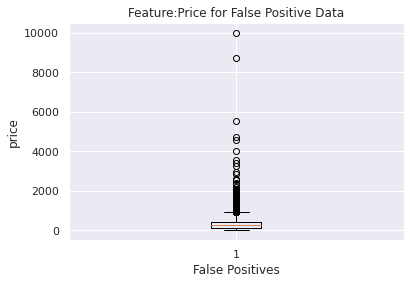

In [ ]:
#box-plot:feature-price
fp_price=fp_data_new.price
plt.boxplot(fp_price)
plt.title("Feature:Price for False Positive Data")
plt.xlabel("False Positives")
plt.ylabel('price')

Text(0.5, 1.0, 'pdf of previously_posted_projects')

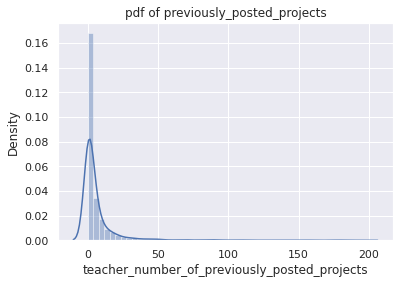

In [ ]:
#pdf of feature:teacher_number_of_previously_posted_projects of fp_data
sns.distplot(fp_data_new['teacher_number_of_previously_posted_projects'])
plt.title('pdf of previously_posted_projects')

In [ ]:
# REF: http://zetcode.com/python/prettytable/

from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Hyper Parameter:Max_Depth", "Hyper Parameter:min_sample_split", " Test AUC"]

x.add_row(["TFIDF", "Decision Tree", bestMaxDepth_1, bestMinSampleSplit_1, 0.634])
x.add_row(["TFIDFW2V", "Decision Tree", bestMaxDepth_2, bestMinSampleSplit_2, 0.618])
x.add_row(["TFIDF_with_feature_importance", "Decision Tree", bestMaxDepth, bestMinSampleSplit, 0.633])

print(x)

+-------------------------------+---------------+---------------------------+----------------------------------+-----------+
|           Vectorizer          |     Model     | Hyper Parameter:Max_Depth | Hyper Parameter:min_sample_split |  Test AUC |
+-------------------------------+---------------+---------------------------+----------------------------------+-----------+
|             TFIDF             | Decision Tree |             10            |               500                |   0.634   |
|            TFIDFW2V           | Decision Tree |             5             |                5                 |   0.618   |
| TFIDF_with_feature_importance | Decision Tree |             10            |               500                |   0.633   |
+-------------------------------+---------------+---------------------------+----------------------------------+-----------+
